In [97]:
# Only Change bag_name

In [318]:
# Imports
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np
import os
from tf.transformations import euler_from_quaternion, quaternion_matrix, euler_matrix

In [338]:
def create_folder(path, folder_name):
    # Join the path and folder name
    folder_path = os.path.join(path, folder_name)
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_name}' created in '{path}'")
    else:
        print(f"Folder '{folder_name}' already exists in '{path}'")

In [339]:
# read rosbag
bag_name = 'my_data_test3'
path_bag = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/" + bag_name + ".bag"
bag = bagpy.bagreader(path_bag)

[INFO]  Data folder /home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/my_data_test3 already exists. Not creating.


In [340]:
# extract topics of interest
odom_data = pd.read_csv(bag.message_by_topic('/odom'))
# position_data = pd.read_csv(bag.message_by_topic('/vehicle_position'))
# velocity_data = pd.read_csv(bag.message_by_topic('/vehicle_velocities'))
estimation_data = pd.read_csv(bag.message_by_topic('/encoder_state_estimation'))

#TODO comment
cmd_data = pd.read_csv(bag.message_by_topic('/cmd_vel'))
cmd_angle_data = pd.read_csv(bag.message_by_topic('/SteeringAngle'))


In [341]:

# Apply the function to each row of the DataFrame and extract the third element
odom_data['pose.pose.orientation.z'] = odom_data.apply(lambda row: euler_from_quaternion((row['pose.pose.orientation.x'], row['pose.pose.orientation.y'], row['pose.pose.orientation.z'], row['pose.pose.orientation.w']))[2], axis=1)


In [342]:
# Select the Desired columns in odom_data
desired_columns_odom = ['Time', 'pose.pose.position.x', 'pose.pose.position.y', 
                   'pose.pose.orientation.z',
                   'twist.twist.linear.x', 'twist.twist.linear.y', 
                   'twist.twist.linear.z', 'twist.twist.angular.z']

desired_columns_encoder = ['Time', 'pose.pose.position.x', 'pose.pose.position.y', 
                   'pose.pose.orientation.z', 'pose.pose.orientation.w' ,
                   'twist.twist.linear.x', 'twist.twist.linear.y', 
                   'twist.twist.linear.z', 'twist.twist.angular.z']

# Select only the desired columns
odom_data = odom_data[desired_columns_odom]
estimation_data = estimation_data[desired_columns_encoder]

# Rename Columns
odom_data = odom_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity',
    'pose.pose.position.x': 'position_x',
    'pose.pose.position.y': 'position_y',
    'pose.pose.orientation.z': 'theta_z',
    'twist.twist.linear.x': 'velocity_x',
    'twist.twist.linear.y': 'velocity_y',
    'twist.twist.angular.z': 'omega_z'
})

estimation_data = estimation_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity_encoder',
    'pose.pose.position.x': 'position_x_encoder',
    'pose.pose.position.y': 'position_y_encoder',
    'pose.pose.orientation.z': 'theta_z_encoder',
    'pose.pose.orientation.w': 'steering_angle_encoder',
    'twist.twist.linear.x': 'velocity_x_encoder',
    'twist.twist.linear.y': 'velocity_y_encoder',
    'twist.twist.angular.z': 'omega_z_encoder'
})

# position_data = position_data.rename(columns={
#     'x' : "encoder_x",
#     'y' : "encoder_y",
#     'z' : "encoder_theta"
# })

# velocity_data = velocity_data.rename(columns={
#     'x' : "encoder_velocity",
#     'y' : "Null",
#     'z' : "encoder_omega"
# })

#TODO comment
cmd_data = cmd_data.rename(columns={
    'data' : "cmd_vel",
})
cmd_angle_data = cmd_angle_data.rename(columns={
    'data' : "cmd_steering_angle",
})


In [343]:
# # Note: select odom offset to use for all topics to uniify time
# Calculate Time offset
offset_odom = odom_data['Time'].iloc[0]
# offset_pos  = position_data['Time'].iloc[0]
# offset_vel  = velocity_data['Time'].iloc[0]
# offset_cmd = cmd_data['Time'].iloc[0] #TODO comment

# Subtract the offset from all values in the "Time" column
odom_data['Time'] = odom_data['Time'] - offset_odom
estimation_data['Time'] = estimation_data['Time'] - offset_odom
# position_data['Time'] = position_data['Time'] - offset_odom
# velocity_data['Time'] = velocity_data['Time'] - offset_odom

cmd_data['Time'] = cmd_data['Time'] - offset_odom #TODO comment
cmd_angle_data['Time'] = cmd_angle_data['Time'] - offset_odom #TODO comment

# print(f"Odom: {offset_odom}\npos : {offset_pos}\nvel : {offset_vel}")

In [344]:
# Calculate Euclidean distance (magnitude) from velocity_x and velocity_y
odom_data['linear_velocity'] = np.sqrt(odom_data['velocity_x']**2 + odom_data['velocity_y']**2)
odom_data['theta_z'] = np.rad2deg(odom_data['theta_z'])
odom_data['omega_z'] = np.rad2deg(odom_data['omega_z'])
estimation_data['linear_velocity_encoder'] = np.sqrt(estimation_data['velocity_x_encoder']**2 + estimation_data['velocity_y_encoder']**2)
estimation_data['steering_angle_encoder'] = np.rad2deg( estimation_data['steering_angle_encoder'] )

cmd_data['cmd_vel'] = 33.33*cmd_data['cmd_vel']

In [345]:
odom_data.head()

estimation_data.head()

# position_data.head()
# velocity_data.head()

cmd_data.head()

cmd_angle_data.head()

,Time,cmd_steering_angle
0,-0.204214,-9.999259


In [346]:
# odom_data.shape

# estimation_data.shape

## position_data.shape
## velocity_data.shape

# cmd_data.shape
# cmd_angle_data.shape

In [347]:
# Perform asof merge on the closest timestamps
merged_data = pd.merge_asof(odom_data, estimation_data, on="Time")
# merged_data = pd.merge_asof(odom_data, position_data, on="Time")
# merged_data = pd.merge_asof(merged_data, velocity_data, on="Time")
merged_data = pd.merge_asof(merged_data, cmd_data, on="Time")
merged_data = pd.merge_asof(merged_data, cmd_angle_data, on="Time")

# Create a new DataFrame with the desired columns
my_data = pd.DataFrame({
    'Time': merged_data['Time'],
    'position_x': merged_data['position_x'],
    'encoder_x': merged_data['position_x_encoder'],
    'position_y': merged_data['position_y'],
    'encoder_y': merged_data['position_y_encoder'],
    'theta' : merged_data['theta_z'],  #TODO
    'encoder_theta': merged_data['theta_z_encoder'],
    'linear_velocity': merged_data['linear_velocity'],
    'encoder_velocity': merged_data['linear_velocity_encoder'],
    
    'cmd_velocity' : merged_data['cmd_vel'], #TODO comment
    'cmd_steering' : merged_data['cmd_steering_angle'],
    'steering_angle_encoder' : merged_data['steering_angle_encoder'],
    'omega_z': merged_data['omega_z'],
    'encoder_omega': merged_data['omega_z_encoder']
})

#reset the index of the new DataFrame
my_data = my_data.reset_index(drop=True)


In [348]:
# # Note: Either subtract time offset after merger or select only one time offset to all topics with [odom]
# # Calculate Time offset
# offset_my_data = my_data['Time'].iloc[0]

# # Subtract the offset from all values in the "Time" column
# my_data['Time'] = my_data['Time'] - offset_my_data

In [349]:
my_data.head(20)

# my_data.tail()

,Time,position_x,encoder_x,position_y,encoder_y,theta,encoder_theta,linear_velocity,encoder_velocity,cmd_velocity,cmd_steering,steering_angle_encoder,omega_z,encoder_omega
0,0.000000,0.000268,NaN,0.000585,NaN,0.028099,NaN,0.032699,NaN,2.0,-9.999259,NaN,0.489042,NaN
1,0.007014,0.000310,NaN,0.000880,NaN,0.030914,NaN,0.029801,NaN,2.0,-9.999259,NaN,0.281562,NaN
2,0.013912,0.000382,NaN,0.001106,NaN,0.030792,NaN,0.023689,NaN,2.0,-9.999259,NaN,-0.012255,NaN
3,0.020990,0.000434,NaN,0.001288,NaN,0.032734,NaN,0.018948,NaN,2.0,-9.999259,NaN,0.194265,NaN
4,0.027841,0.000507,NaN,0.001400,NaN,0.032990,NaN,0.013305,NaN,2.0,-9.999259,NaN,0.025657,NaN
5,0.034721,0.000565,NaN,0.001465,NaN,0.034966,NaN,0.008732,NaN,2.0,-9.999259,NaN,0.197604,NaN
6,0.041611,0.000616,NaN,0.001482,NaN,0.037359,NaN,0.005423,NaN,2.0,-9.999259,NaN,0.239321,NaN
7,0.048591,0.000639,NaN,0.001479,NaN,0.041111,NaN,0.002329,NaN,2.0,-9.999259,NaN,0.375167,NaN
8,0.055543,0.000653,NaN,0.001454,NaN,0.044325,NaN,0.002928,NaN,2.0,-9.999259,NaN,0.321478,NaN
9,0.062503,0.000664,NaN,0.001429,NaN,0.046752,NaN,0.002684,NaN,2.0,-9.999259,NaN,0.242800,NaN


In [350]:
# set Save path:
folder = bag_name + "/"
plot_save_path = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/"
create_folder(plot_save_path, folder)
plot_save_path = plot_save_path + folder

Folder 'my_data_test3/' already exists in '/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/'


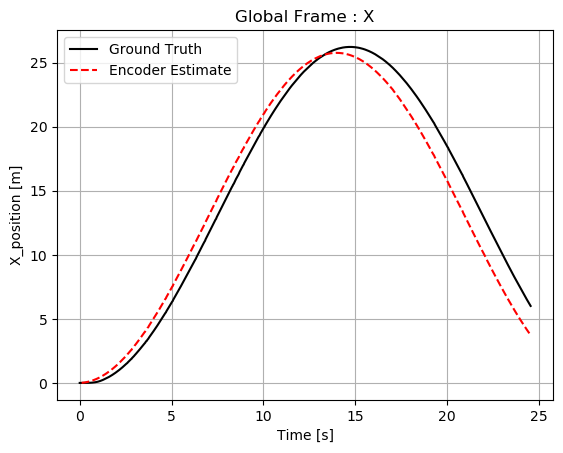

In [351]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position_x and encoder_x against Time
plt.plot(my_data['Time'].values, my_data['position_x'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_x'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('X_position [m]')
plt.title('Global Frame : X Position')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_X.png")
# Show plot
plt.show()

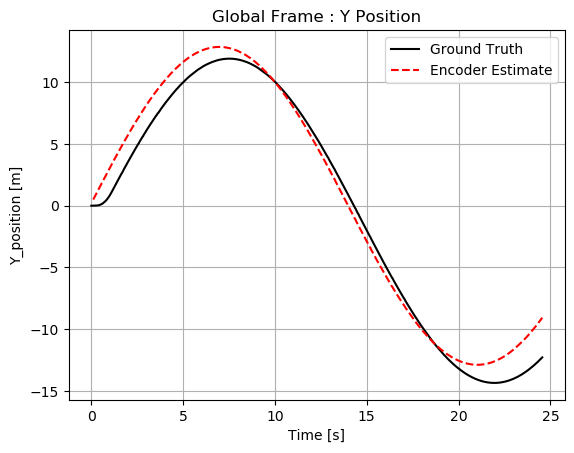

In [357]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position Y
plt.plot(my_data['Time'].values, my_data['position_y'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_y'].values,
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Y_position [m]')
plt.title('Global Frame : Y Position')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_Y.png")
# Show plot
plt.show()


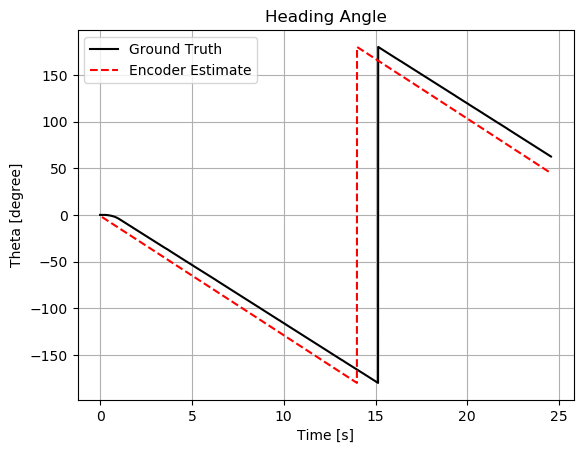

In [353]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position Y
plt.plot(my_data['Time'].values, my_data['theta'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_theta'].values,
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Theta [degree]')
plt.title('Heading Angle')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"orientation_Z.png")
# Show plot
plt.show()


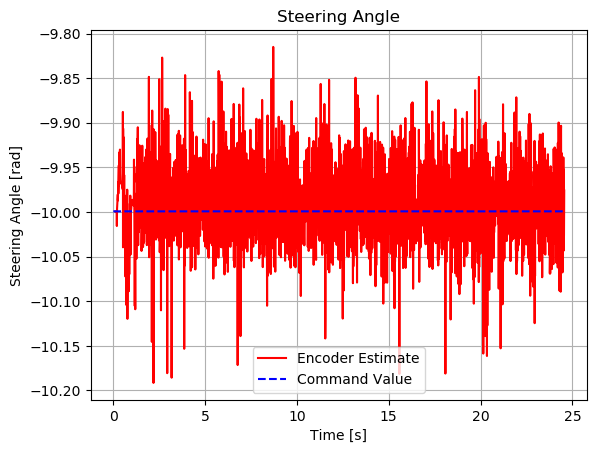

In [354]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both linear velocity and encoder velocity on the same plot
plt.plot(my_data['Time'].values, my_data['steering_angle_encoder'].values, 
         'r',
         label='Encoder Estimate')
plt.plot(my_data['Time'].values, my_data['cmd_steering'].values, 
         'b--',
         label='Command Value')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Steering Angle [rad]')
plt.title('Steering Angle')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"steering.png")
# Show plot
plt.show()


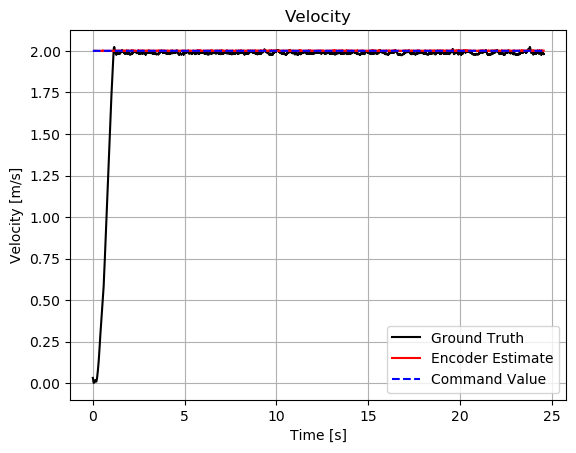

In [355]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both linear velocity and encoder velocity on the same plot
plt.plot(my_data['Time'].values, my_data['linear_velocity'].values, 
         'k',
         label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_velocity'].values, 
         'r',
         label='Encoder Estimate')
plt.plot(my_data['Time'].values, my_data['cmd_velocity'].values, 
         'b--',
         label='Command Value')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Velocity')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"velocity.png")
# Show plot
plt.show()


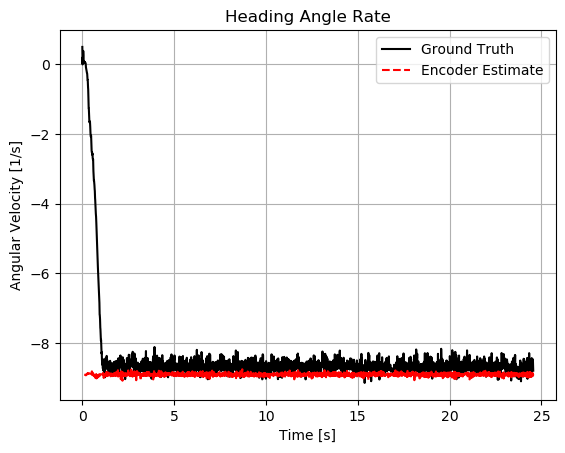

In [356]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both omega_z and encoder_omega on the same plot
plt.plot(my_data['Time'].values, my_data['omega_z'].values,
        'k', 
        label='Ground Truth')

plt.plot(my_data['Time'].values, my_data['encoder_omega'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [1/s]')
plt.title('Heading Angle Rate')

# Add legend
plt.legend()

# Add grid
plt.grid(True)


# Save plot to file
plt.savefig(plot_save_path+"omega.png")
# Show plot
plt.show()


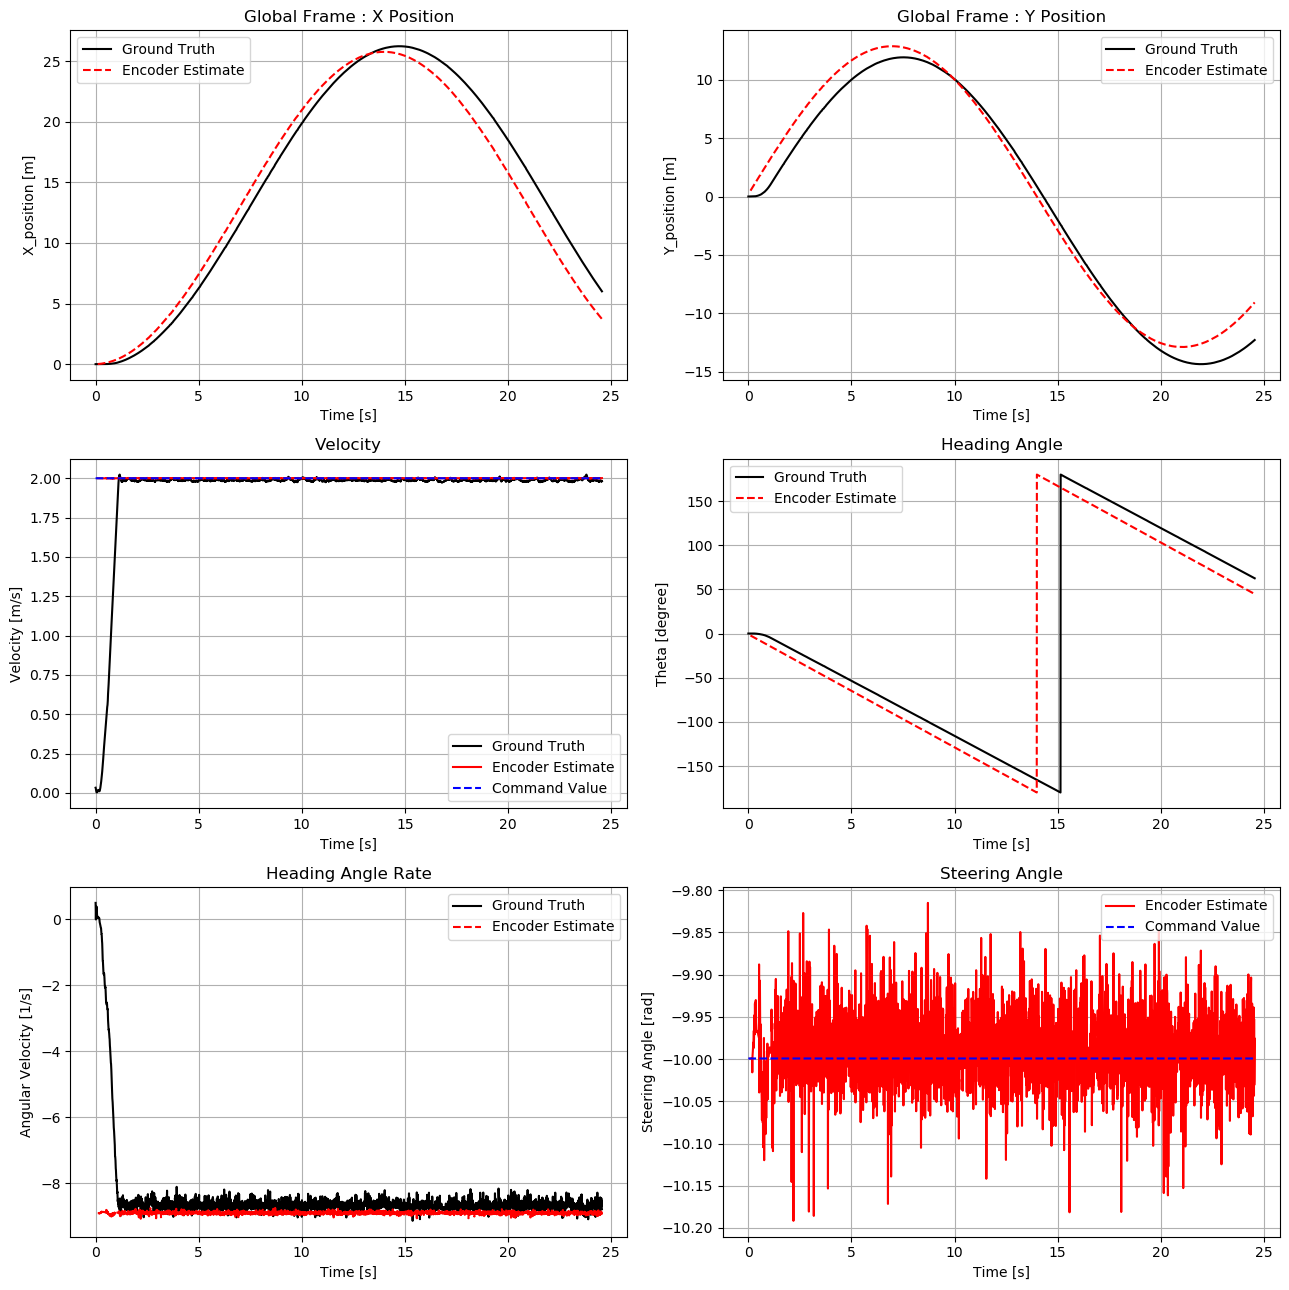

In [359]:
# Create a figure with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(13, 13))  # Width: 15 inches, Height: 15 inches

# Plot 1
axs[0, 0].plot(my_data['Time'].values, my_data['position_x'].values, 'k', label='Ground Truth')
axs[0, 0].plot(my_data['Time'].values, my_data['encoder_x'].values, 'r--', label='Encoder Estimate')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('X_position [m]')
axs[0, 0].set_title('Global Frame : X Position')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2
axs[0, 1].plot(my_data['Time'].values, my_data['position_y'].values, 'k', label='Ground Truth')
axs[0, 1].plot(my_data['Time'].values, my_data['encoder_y'].values, 'r--', label='Encoder Estimate')
axs[0, 1].set_xlabel('Time [s]')
axs[0, 1].set_ylabel('Y_position [m]')
axs[0, 1].set_title('Global Frame : Y Position')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3
axs[1, 0].plot(my_data['Time'].values, my_data['linear_velocity'].values, 'k', label='Ground Truth')
axs[1, 0].plot(my_data['Time'].values, my_data['encoder_velocity'].values, 'r', label='Encoder Estimate')
axs[1, 0].plot(my_data['Time'].values, my_data['cmd_velocity'].values, 'b--', label='Command Value')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Velocity [m/s]')
axs[1, 0].set_title('Velocity')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4
axs[1, 1].plot(my_data['Time'].values, my_data['theta'].values, 'k', label='Ground Truth')
axs[1, 1].plot(my_data['Time'].values, my_data['encoder_theta'].values, 'r--', label='Encoder Estimate')
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Theta [degree]')
axs[1, 1].set_title('Heading Angle')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot 5
axs[2, 0].plot(my_data['Time'].values, my_data['omega_z'].values, 'k', label='Ground Truth')
axs[2, 0].plot(my_data['Time'].values, my_data['encoder_omega'].values, 'r--', label='Encoder Estimate')
axs[2, 0].set_xlabel('Time [s]')
axs[2, 0].set_ylabel('Angular Velocity [1/s]')
axs[2, 0].set_title('Heading Angle Rate')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot 6
axs[2, 1].plot(my_data['Time'].values, my_data['steering_angle_encoder'].values, 'r', label='Encoder Estimate')
axs[2, 1].plot(my_data['Time'].values, my_data['cmd_steering'].values, 'b--', label='Command Value')
axs[2, 1].set_xlabel('Time [s]')
axs[2, 1].set_ylabel('Steering Angle [rad]')
axs[2, 1].set_title('Steering Angle')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Save plot to file
plt.savefig(plot_save_path+"All_Data.png")

# Show the plot
plt.show()
